In this notebook, we shall use a single-cell RNAseq data to deconvolve a bulk RNAseq data.

## Datasets needed for tutorial

The datasets used in this tutorial are available as part the [DISSECT](https://github.com/robinredX/DISSECT/tutorials/data) repository. 

Sources:

The bulk RNAseq data is taken from [GSE120502](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120502).

The single-cell RNAseq data comes from 10x Genomics and for this tutorial, we will use a sampled dataset containing 1000 cells. The complete count matrix can be downloaded at [this link] (http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz). 

### A note on the supported formats

**(1) bulkRNAseq**

The gene IDs can be gene symbols, ENSEMBL etc. as long as same format is used for the scRNAseq data. 

A tab seperated file (gene symbols in rows, sample names in columns) as can be seen below:

In [1]:
import pandas as pd

bulk_path = "data/bulkRNAseq/bulk_gse120502.txt"

df = pd.read_table(bulk_path, index_col=0)
df.head()

T63_LPS_FC1_4  T81_LPS_FC1_4  T104_LPS_FC1_4  T4_GARD_BATCH_2  \
ATF7-NPFF              29.0           28.0            38.0             71.0   
B4GAT1-DT              15.0           16.0            28.0             44.0   
BTBD8                   0.0            3.0             4.0             36.0   
C12orf42-AS1            0.0            0.0             0.0              0.0   
C4orf54                 0.0            2.0             0.0              6.0   

              K47_LPS_FC1_4  T4_CTL_FC5  T12_CTL_B_BATCH_2  T84_LPS_FC1_4  \
ATF7-NPFF              40.0        34.0               39.0           25.0   
B4GAT1-DT               7.0        24.0               44.0           28.0   
BTBD8                  13.0         6.0               30.0           23.0   
C12orf42-AS1            0.0         0.0                0.0            0.0   
C4orf54                 0.0         0.0                0.0            0.0   

              K44_LPS_FC1_4  K10_LPS_FC1_4  ...  T70_LPS_FC1_4  \
ATF7-NPFF              58.0           38.0  ...           30.0   
B4GAT1-DT              23.0           18.0  ...           32.0   
BTBD8                  37.0           13.0  ...            5.0   
C12orf42-AS1            0.0            0.0  ...            0.0   
C4orf54                 0.0            0.0  ...            0.0   

              K10_GARD_BATCH_2  K37_CTL_FC1_4  T5_CTL_FC5  K53_LPS_FC1_4  \
ATF7-NPFF                 52.0           31.0        27.0           34.0   
B4GAT1-DT                 24.0           18.0        36.0           13.0   
BTBD8                     12.0           16.0        25.0            0.0   
C12orf42-AS1               0.0            0.0         0.0            0.0   
C4orf54                    0.0            2.0         1.0            0.0   

              T120_LPS_FC5  K7_GARD_BATCH_2  K12_GARD_BATCH_2  \
ATF7-NPFF             22.0             56.0              50.0   
B4GAT1-DT              4.0             43.0              37.0   
BTBD8                  0.0             23.0              22.0   
C12orf42-AS1           0.0              0.0               0.0   
C4orf54                0.0              0.0               0.0   

              T35_GARD_BATCH_2  K50_CTL_FC1_4  
ATF7-NPFF                 50.0           24.0  
B4GAT1-DT                 47.0           16.0  
BTBD8                     46.0           32.0  
C12orf42-AS1               0.0            0.0  
C4orf54                    0.0            1.0  

[5 rows x 250 columns]

The other supported format is h5ad compatible with Scanpy >=1.8.0. This format is identical to the format of scRNAseq object as shown below.

**(2) scRNAseq**

A h5ad compatible with Scanpy >=1.8.0. 

Metadata included in .obs attribute as can be seen below:

In [2]:
import scanpy as sc
sc_path = "data/scRNAseq/sampled_100_data8k.h5ad"
adata = sc.read(sc_path)
adata

AnnData object with n_obs × n_vars = 1000 × 18159
    obs: 'cell_type'

In [3]:
adata.obs

cell_type
cell_7406  CD4Tcells
cell_4119  CD4Tcells
cell_3032  CD4Tcells
cell_3795         NK
cell_318   Monocytes
...              ...
cell_6912  CD4Tcells
cell_5269  CD8Tcells
cell_7541  Monocytes
cell_4880  Monocytes
cell_3135     Bcells

[1000 rows x 1 columns]

From the metadata, we need names of cell type column and batch column (if any).

adata.X must contain raw counts. This can be checked by checking the maximum value which will be high integer value (>100).

In [4]:
adata.X.max()

733.0

## Import DISSECT module

In [5]:
import dissect

DISSECT can be configured with a config file available from the following command.

In [6]:
config = dissect.config

In [7]:
config

{'experiment_folder': '/home/user/experiment',
 'simulation_params': {'scdata': '/home/user/experiment/data.h5ad',
  'n_samples': None,
  'type': 'bulk',
  'celltype_col': 'celltype',
  'batch_col': None,
  'cells_per_sample': 500,
  'downsample': None,
  'preprocess': None,
  'filter': {'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0},
  'concentration': None,
  'prop_sparse': 0.5,
  'generate_component_figures': True},
 'deconv_params': {'test_dataset': '../bulk.txt',
  'test_dataset_format': 'txt',
  'test_dataset_type': 'bulk',
  'duplicated': 'first',
  'normalize_simulated': 'cpm',
  'normalize_test': 'cpm',
  'var_cutoff': 0.1,
  'test_in_mix': None,
  'simulated': True,
  'sig_matrix': False,
  'mix': 'srm',
  'save_config': True,
  'network_params': {'n_hidden_layers': 4,
   'hidden_units': [512, 256, 128, 64],
   'hidden_activation': 'relu6',
   'output_activation': 'softmax',
   'loss': 'kldivergence',
   'n_steps': 5000,
   'lr': 1e-05,
   'batch_size': 64,


Description of each hyperparameter can be seen with the following function

In [8]:
dissect.config_info()

config = {

    "experiment_folder": "/home/user/experiment",  # Path to save outputs. Default: "/home/user/experiment"



    "simulation_params": { 

        "scdata": "/home/user/experiment/data.h5ad",  # Path to sc/snRNA-seq data, should be anndata

        "n_samples": None,  # Number of samples to generate. Default (None): 1000 times the number of celltypes,

        "type": "bulk", # bulk or st to simulate bulk and spatial transcriptomics respectively

        "celltype_col": "celltype",  # Name of the column corresponding to cell-type labels in adata.obs

        "batch_col": None,  # If more than one batches are present, name of the column corrsponding to batch labels in adata.obs

        "cells_per_sample": 500,  # Number of cells to sample to generate one sample.

        "downsample": None,  # If simulation_type is ST, a float is used to downsample counts. Default (None): No downsampling

        "preprocess": None, # Default (None) will no preprocess

        "filter": { 

In application cases, we need to make following changes to this config dictionary: specify paths to our single cell and bulk data, as well as name of the cell type and batch columns. Since for this data, we have no batch column, we only need cell type column, which for the above scRNAseq object is "cell_type". 

In case our bulk data already contains TPM counts, we can set config["normalize_test"] to None. By default (i.e. value=None), 
it performs CPM normalization

**Below, we describe how to make these changes and run the algorithm.**

## Set experiment folder

In this config, **experiment_folder** specifies a non-existing experiment directory where the results would be stored

In [9]:
config["experiment_folder"] # this prints the current folder

'/home/user/experiment'

In [10]:
# we will set it to "tutorial_bulkRNAseq"

config["experiment_folder"] = "tutorial_bulkRNAseq"

## Do simulation

**simulation_params** contain hyperparameters for simulations

We can specify the path to our single-cell data, the data type, our cell type column name, and the number of samples to simulate

In [11]:
config["simulation_params"]["scdata"] = "data/scRNAseq/sampled_100_data8k.h5ad"
config["simulation_params"]["type"] = "bulk"
config["simulation_params"]["celltype_col"] = "cell_type"

In [12]:
# by default the single-cell data passes through following QC:
config["simulation_params"]["filter"]

{'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0}

We will leave all other For other options in the config and their meanings, please look [here](https://github.com/imsb-uke/DISSECT/blob/main/dissect/configs/config.py).

**simulate** function from dissect can be used for simulation. It takes as input the above config.

Outputs

**(1) Simulated data**

Saves the simulated data as h5ad object in the folder simulations/simulated.h5ad within the config["experiment_folder"].

**(2) Plots**

The function also prints and saves the following if config["generate_component_figures"] is set to True (default):

(1) boxplots showing the proportions of cell types in the simulated data,

(2) a scatter plot showing principal components of the simulated data colored by cell type proportions, and

(3) a scatter plot showing principal components of the cell type-specific gene expression profiles for each sample.

Number of batches in single-cell data is 1. If this is incorrect, please specify name of the batch column as in the single-cell data object (.obs)


100%|██████████████████████████████████████| 6000/6000 [00:41<00:00, 144.98it/s]


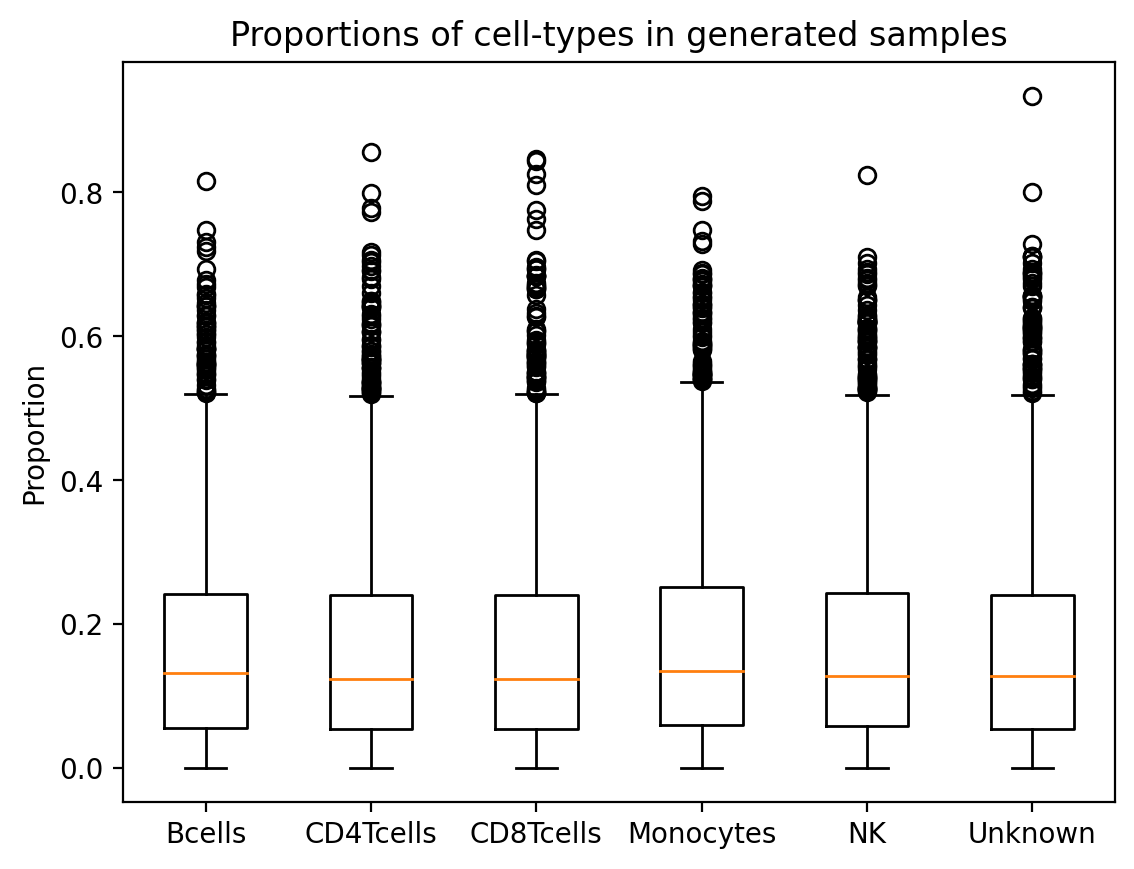

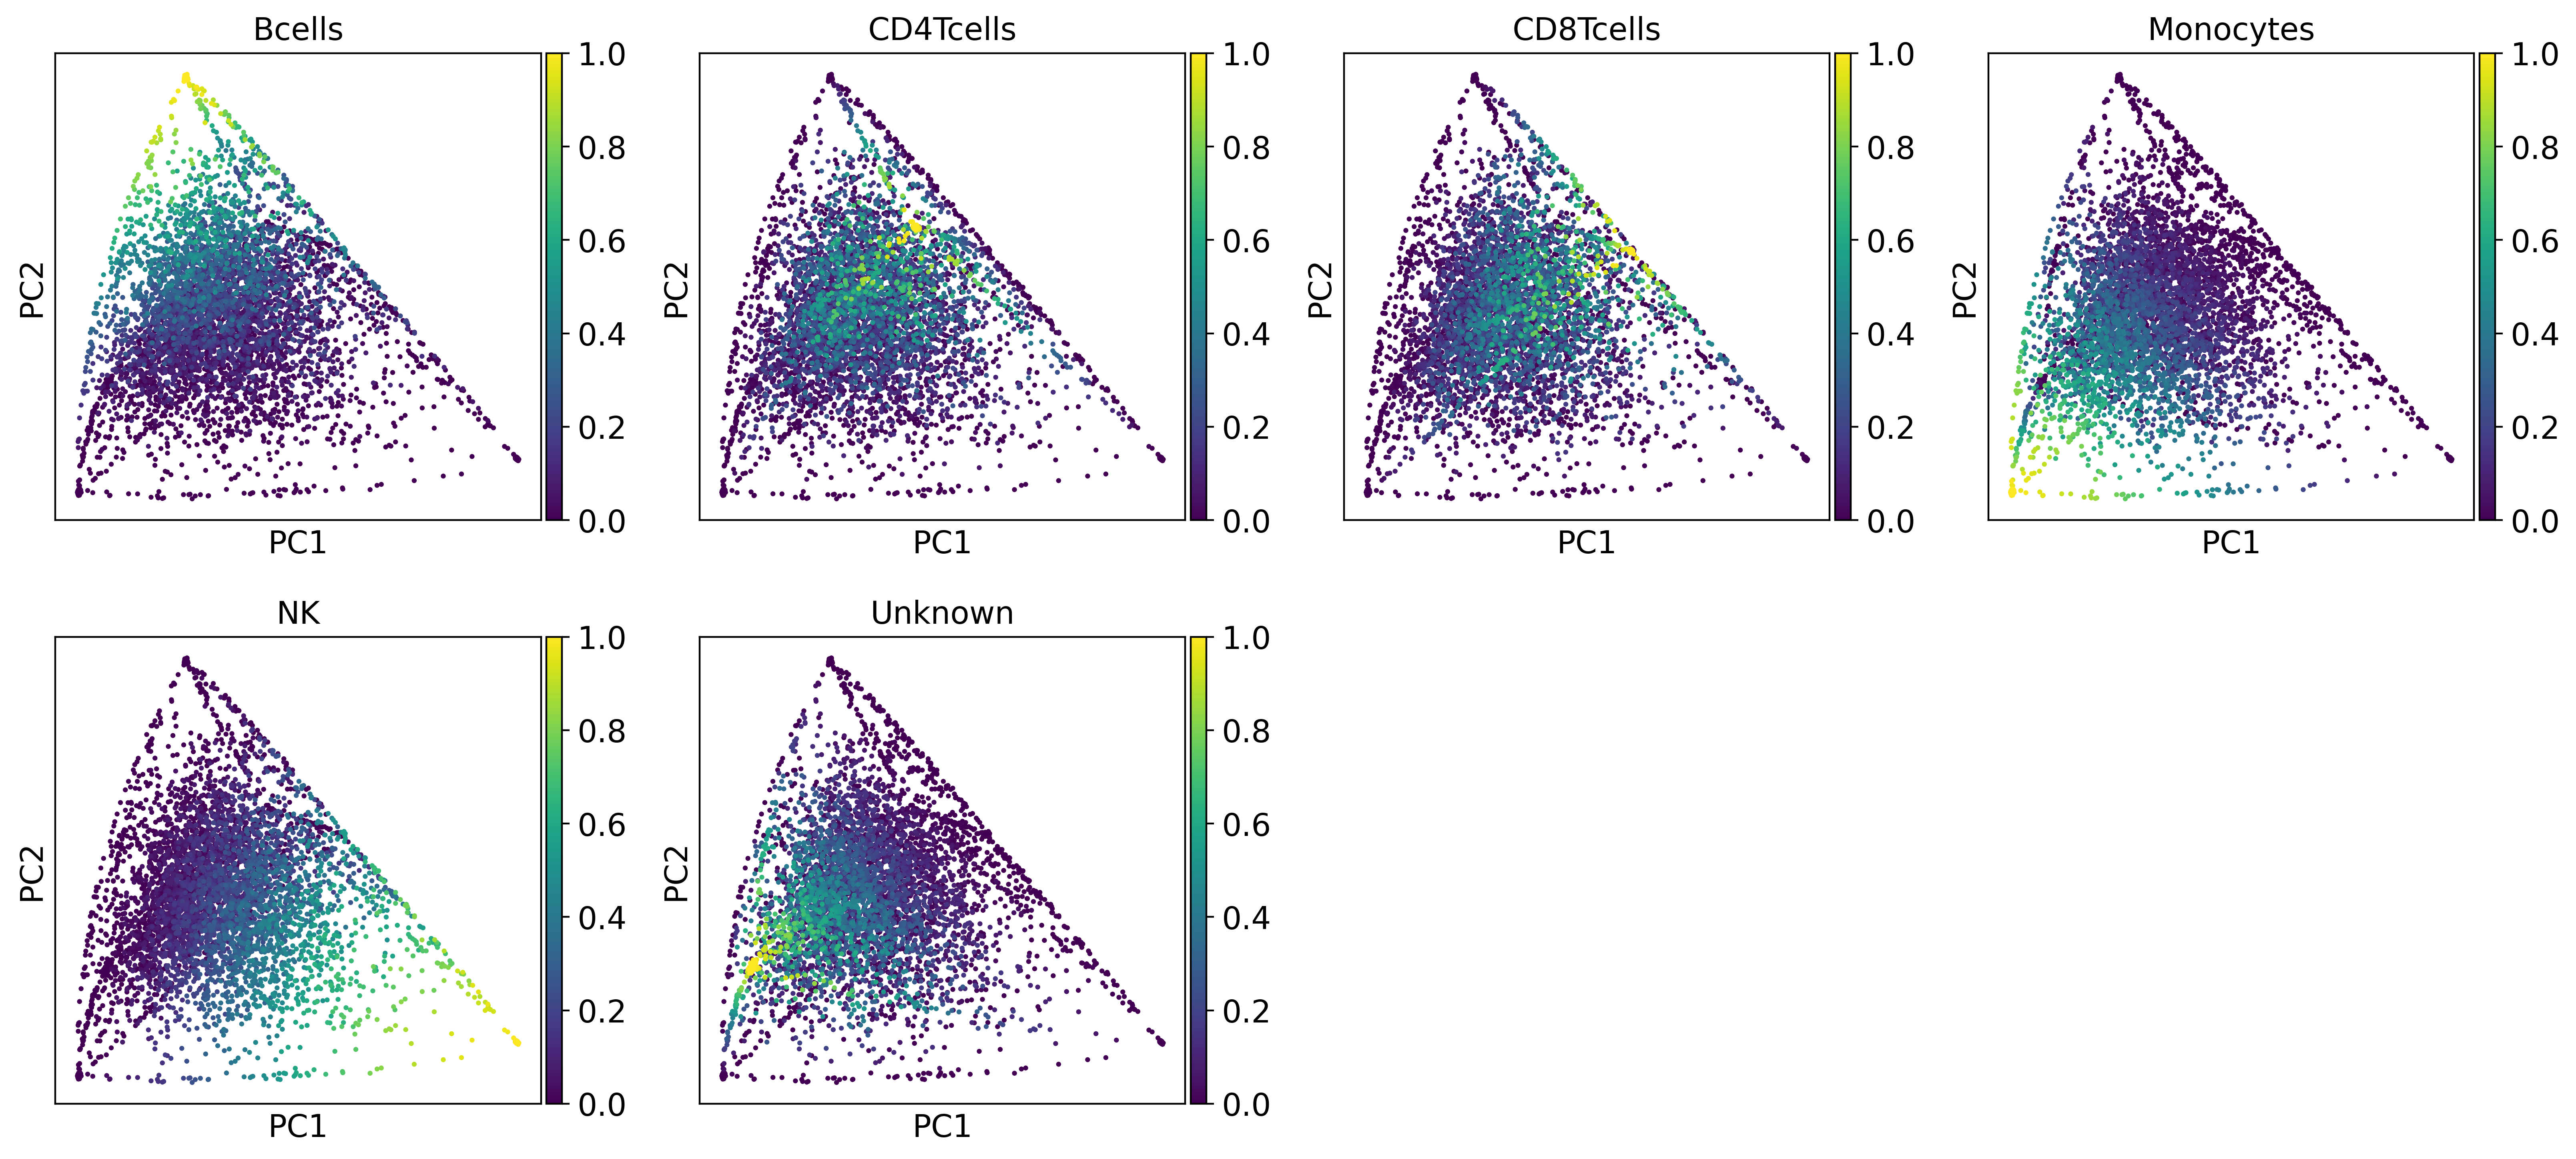

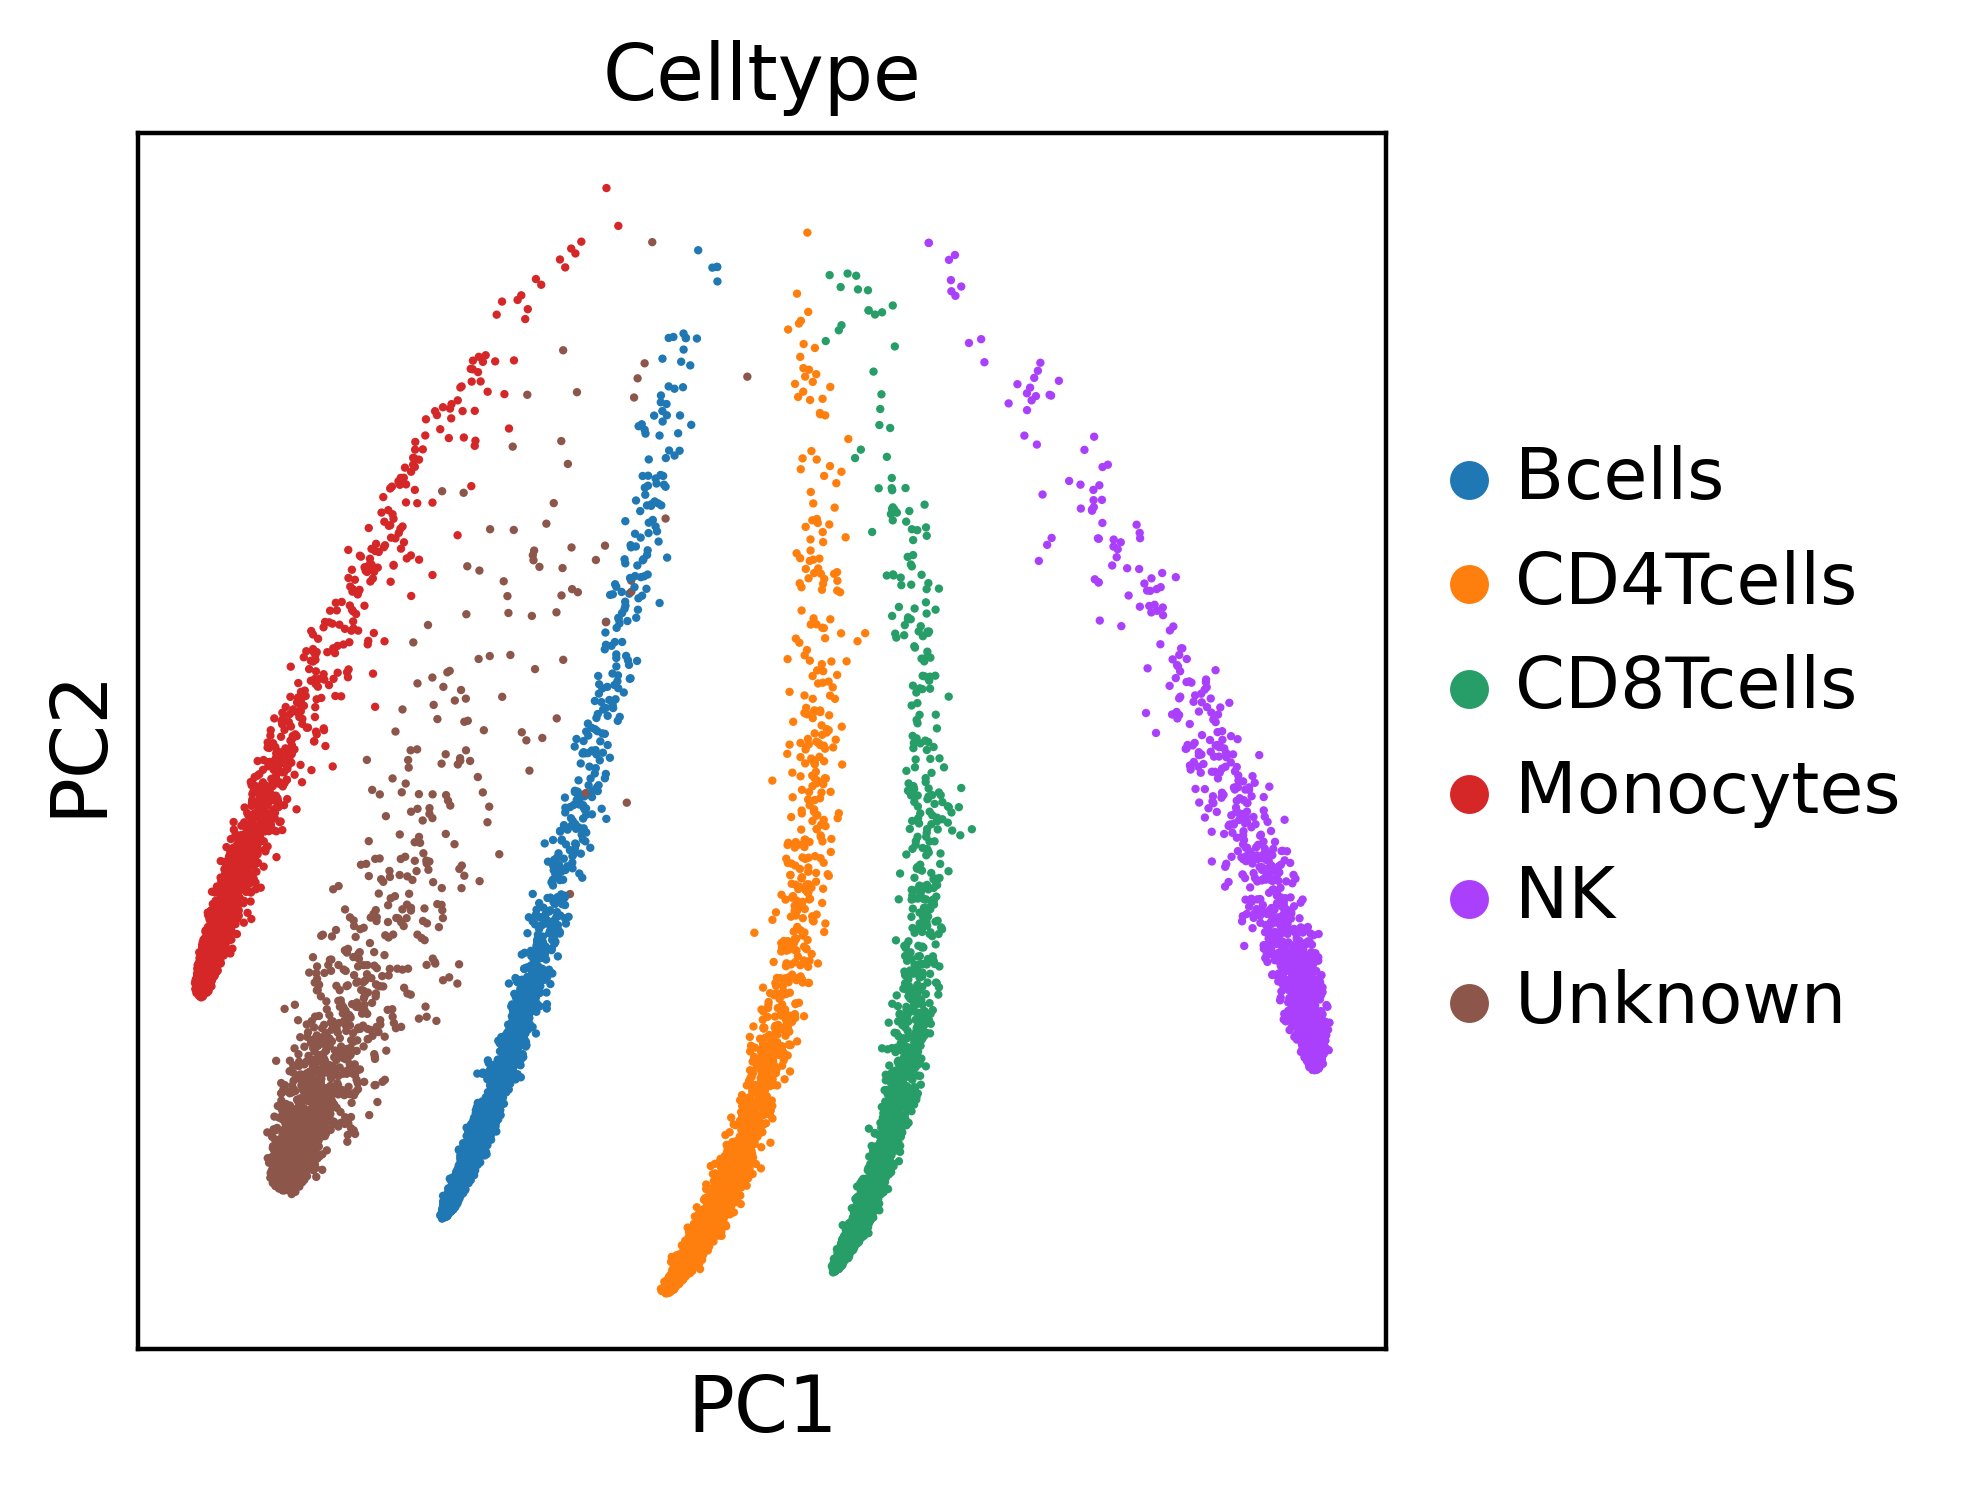

In [13]:
dissect.simulate(config)

# Estimation of fractions

To do this with default parameters, we just need to specify path to bulkRNAseq dataset and its data type

In [12]:
config["deconv_params"]["test_dataset"] = "data/bulkRNAseq/bulk_gse120502.txt"
config["deconv_params"]["test_dataset_format"] = "txt"

In [14]:
# preprocess data
# It does CPM normalization and filters out gene with low variance (default cutoff 0.1).

dissect.dataset(config)

Removing genes which have less than 0.1 variance in their expressions.
test dataset has 16872 distinct and variable genes.
simulated dataset has 13669 distinct genes.
There are 11505 common genes between simulated and test dataset.
Saving numpy files.
Done.


In [15]:
# Estimate fractions
dissect.run_dissect_frac(config)

Loading prepared datasets...
Starting training model 0


step: 5000| loss: 0.0104: 100%|██████████████████████████████████████████████████████| 5000/5000 [02:43<00:00, 30.57it/s]


Starting training model 1


step: 5000| loss: 0.0112: 100%|██████████████████████████████████████████████████████| 5000/5000 [02:42<00:00, 30.84it/s]


Starting training model 2


step: 5000| loss: 0.0127: 100%|██████████████████████████████████████████████████████| 5000/5000 [02:40<00:00, 31.21it/s]


Starting training model 3


step: 5000| loss: 0.0135: 100%|██████████████████████████████████████████████████████| 5000/5000 [02:41<00:00, 30.90it/s]


Starting training model 4


step: 5000| loss: 0.0106: 100%|██████████████████████████████████████████████████████| 5000/5000 [02:39<00:00, 31.36it/s]


Predictions are saved to tutorial_bulkRNAseq/dissect_fractions.txt


The resulting files for each model is saved as dissect_fractions_[model_number].txt in the experiment folder specified in config["experiment_folder"].

Let's load our results and see how it is structured, how we can visualize it and use it for downstream analysis.

In [16]:
import os
result_path = os.path.join(config["experiment_folder"],
                          "dissect_fractions.txt")

df = pd.read_table(result_path, index_col=0)
df.head()

Bcells  CD4Tcells  CD8Tcells  Monocytes        NK   Unknown
T63_LPS_FC1_4    0.050998   0.264567   0.298605   0.185140  0.094879  0.105810
T81_LPS_FC1_4    0.116595   0.326707   0.239222   0.145019  0.054338  0.118119
T104_LPS_FC1_4   0.041435   0.470600   0.228636   0.106191  0.062100  0.091038
T4_GARD_BATCH_2  0.079613   0.358756   0.294246   0.090234  0.083928  0.093222
K47_LPS_FC1_4    0.073276   0.292910   0.236181   0.200853  0.076844  0.119935

In [17]:
## Show cell type composition of each sample

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3) # set figure params

Text(0, 0.5, 'Estimate')

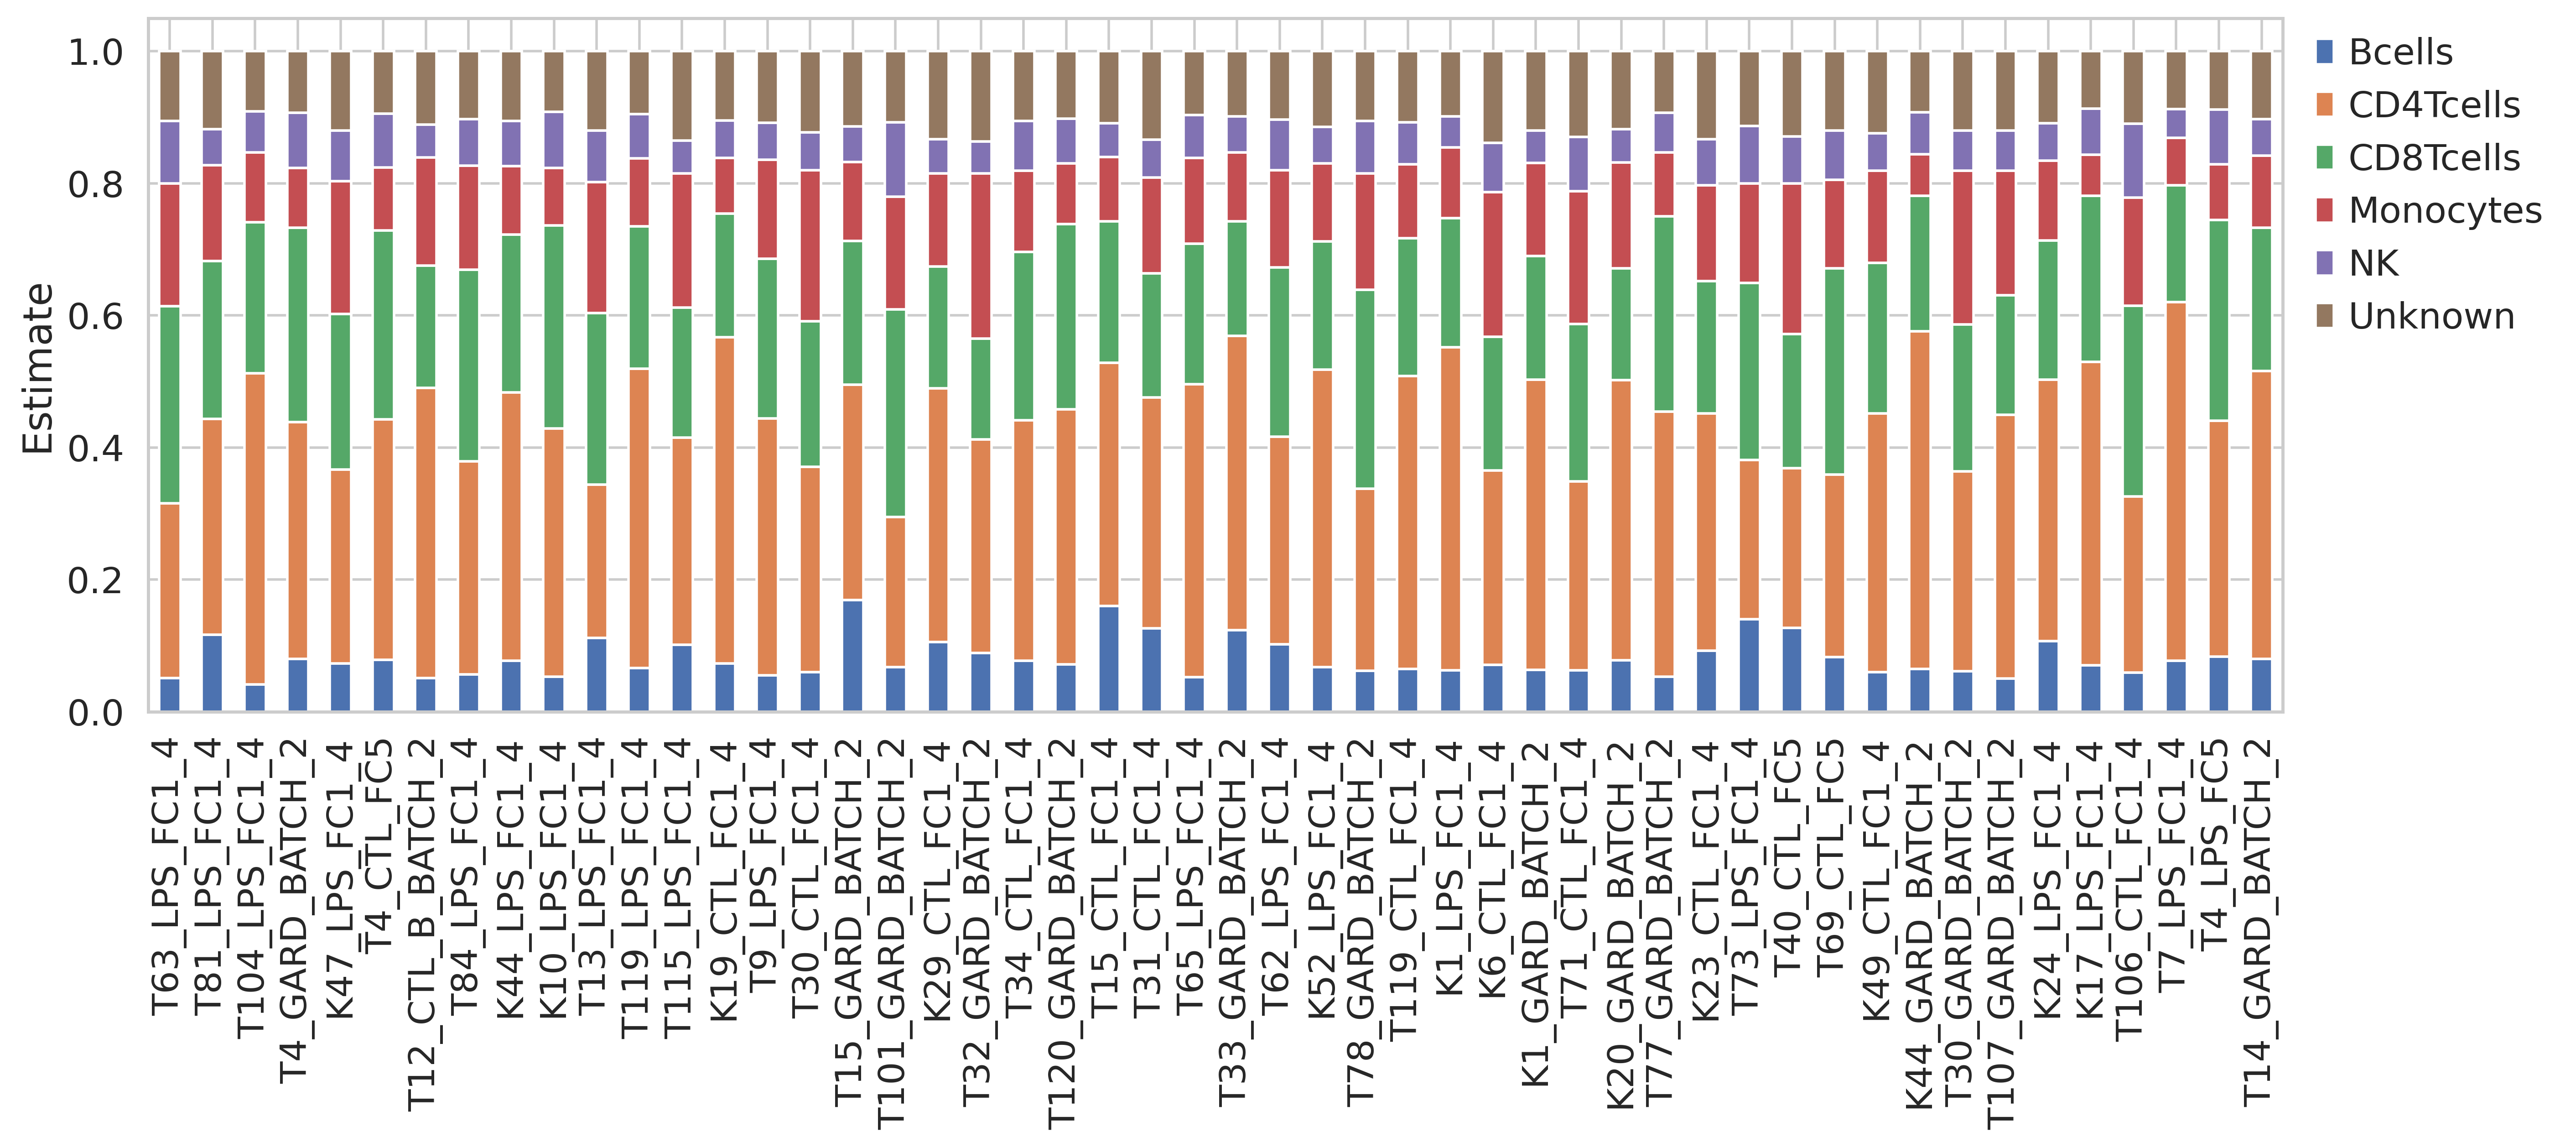

In [19]:
show_samples = 50 # We will show composition of the first 50 samples. 
# show estimates of first 50 samples. More gets hard to see.
df.iloc[0:show_samples,:].plot(kind='bar', stacked=True, figsize=(15,5))
plt.legend(bbox_to_anchor=(1,1.02), frameon=False)
plt.ylabel("Estimate")

In [20]:
## Show distribution of cell type proportions

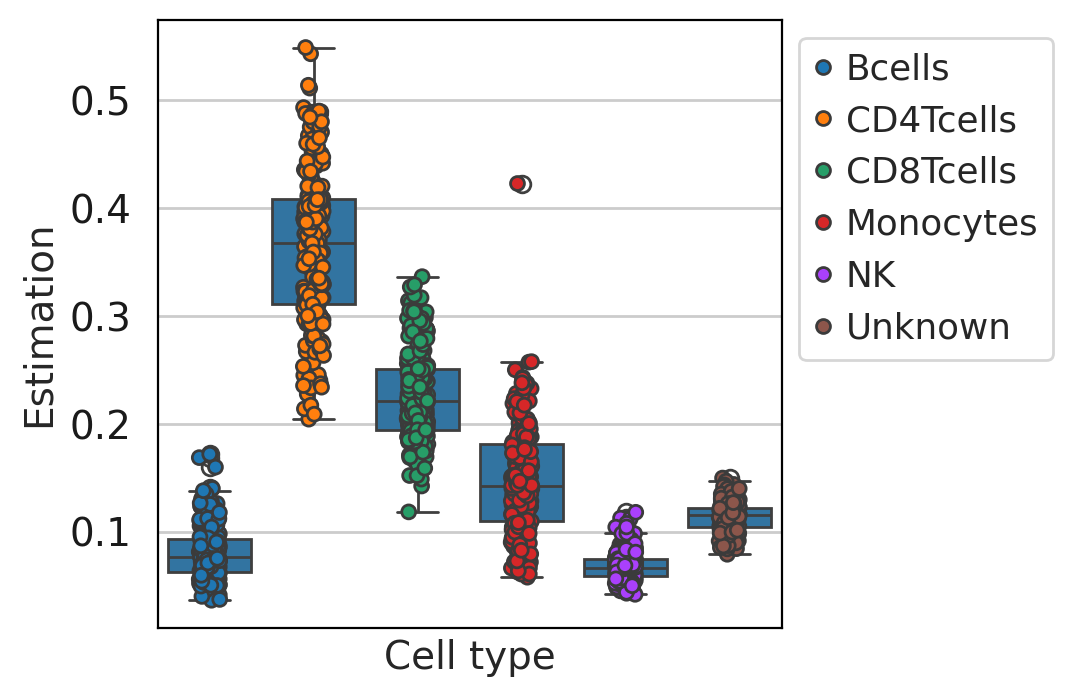

In [21]:
sc.set_figure_params(dpi=100)
melted = df.melt(var_name="Cell type", value_name="Estimation")
ax = sns.boxplot(data=melted, x="Cell type", y="Estimation")

sns.stripplot(data=melted, x="Cell type", y="Estimation", linewidth=1, edgecolor="gray", ax=ax, hue="Cell type", legend=True)
ax.set_xticks([],[])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

-----

## Estimation of cell type specific gene expression 

In [13]:
config["deconv_params"]["reference"] = "tutorial_bulkRNAseq/simulation/simulated.h5ad"

In [16]:
# Estimate cell type specific gene expression
dissect.run_dissect_expr(config)

Estimating expression of 11529 common genes
Preparing training datasets.


100%|████████████████████████████████████████████████████████████████████████████████████| 55/55 [35:30<00:00, 38.74s/it]


Estimated gene expression per cell type is saved at tutorial_bulkRNAseq/est_expression_layered.h5ad and is included in the layers attribute of the anndata object.
Estimated gene expression per cell type for all samples is saved at tutorial_bulkRNAseq/est_expression.h5ad, corresponding samples are in sample attribute of the anndata.obs.


It saves dataset in two ways:
    
**(1)** an h5ad file (est_expression_layered.h5ad) containing counts of bulkRNAseq in .X and corresponding gene expression for each cell type in layers.

**(2)** an h5ad file (est_expression.h5ad) containing counts of cell type specific gene expressions in .X and corresponding sample and cell type name in .obs.

Let's load our results and see how it is structured, how we can visualize it and use it for downstream analysis.

In [75]:
adata_est_layered = sc.read("tutorial_bulkRNAseq/est_expression_layered.h5ad")
print(adata_est_layered)

adata_est = sc.read("tutorial_bulkRNAseq/est_expression.h5ad")
print(adata_est)

AnnData object with n_obs × n_vars = 250 × 11529
    layers: 'Bcells', 'CD4Tcells', 'CD8Tcells', 'Monocytes', 'NK', 'Unknown'
AnnData object with n_obs × n_vars = 1500 × 11529
    obs: 'sample', 'cell_type'
    layers: 'scaled_counts'


-----

Since the data object is compatible with Scanpy, default Scanpy functions can be used. Below we shall show an example

In [76]:
sc.set_figure_params(dpi=50)

show expression of highly variable genes

In [77]:
sc.pp.normalize_total(adata_est, target_sum=1e6)
sc.pp.log1p(adata_est)
sc.pp.highly_variable_genes(adata_est)

In [78]:
n_hvg = adata_est.var[adata_est.var.highly_variable].sort_values(by="dispersions",
                                                        ascending=False).index[0:100]

# Show PCA

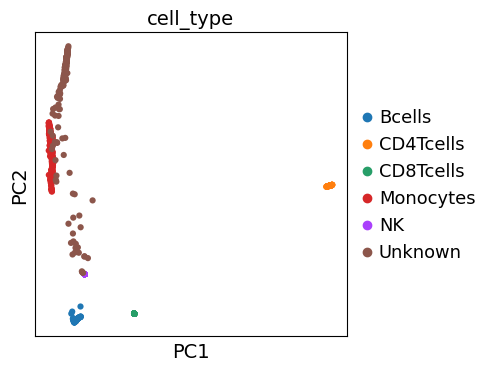

In [79]:
sc.tl.pca(adata_est)
sc.pl.pca(adata_est, color="cell_type")

# Show highly variable genes

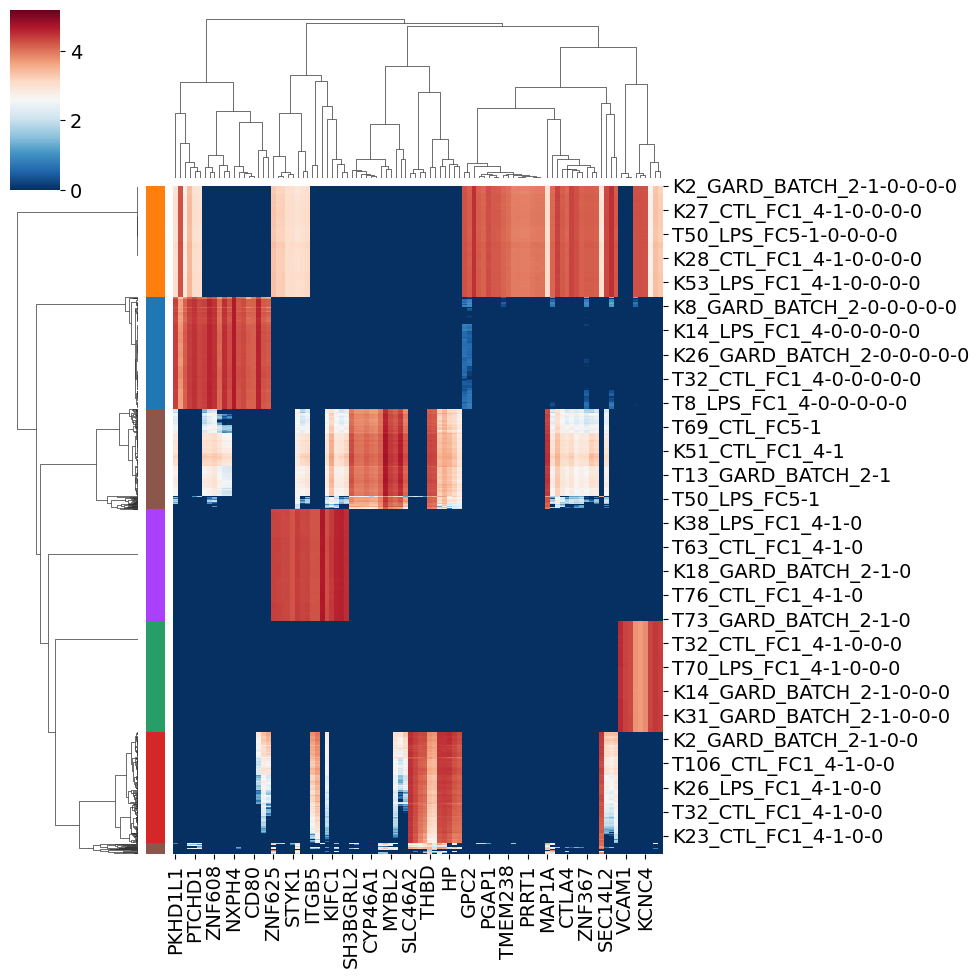

In [80]:
sc.pl.clustermap(adata_est[:, n_hvg], 
                obs_keys="cell_type", cmap="RdBu_r")

In [26]:
adata_est_layered = sc.read("tutorial_bulkRNAseq/est_expression.h5ad")

## Compare cell type marker genes between original bulk mixture and cell type specific gene expression

In [73]:
cell_type_markers = ["CD3D", "CD3E", # T cells,
                     "LYZ", "CD14", # Monocytes
                     "NKG7", "GNLY", # NK cells]
                    "CD19", "CD74" # B cells]
                    ] 

## prepare data

We'll start with layered data and attach cell type expression in a loop

In [74]:
adata_c = adata_est_layered.copy()
adata_c.obs["cell_type"] = "bulk_mixture"
sc.pp.normalize_total(adata_c, target_sum=1e6)
sc.pp.log1p(adata_c)
for layer in adata_est_layered.layers:
    tmp = adata_est_layered.copy()
    tmp.X = tmp.layers[layer]
    tmp.obs["cell_type"] = layer 
    adata_c = adata_c.concatenate(tmp)
    

## Violinplot

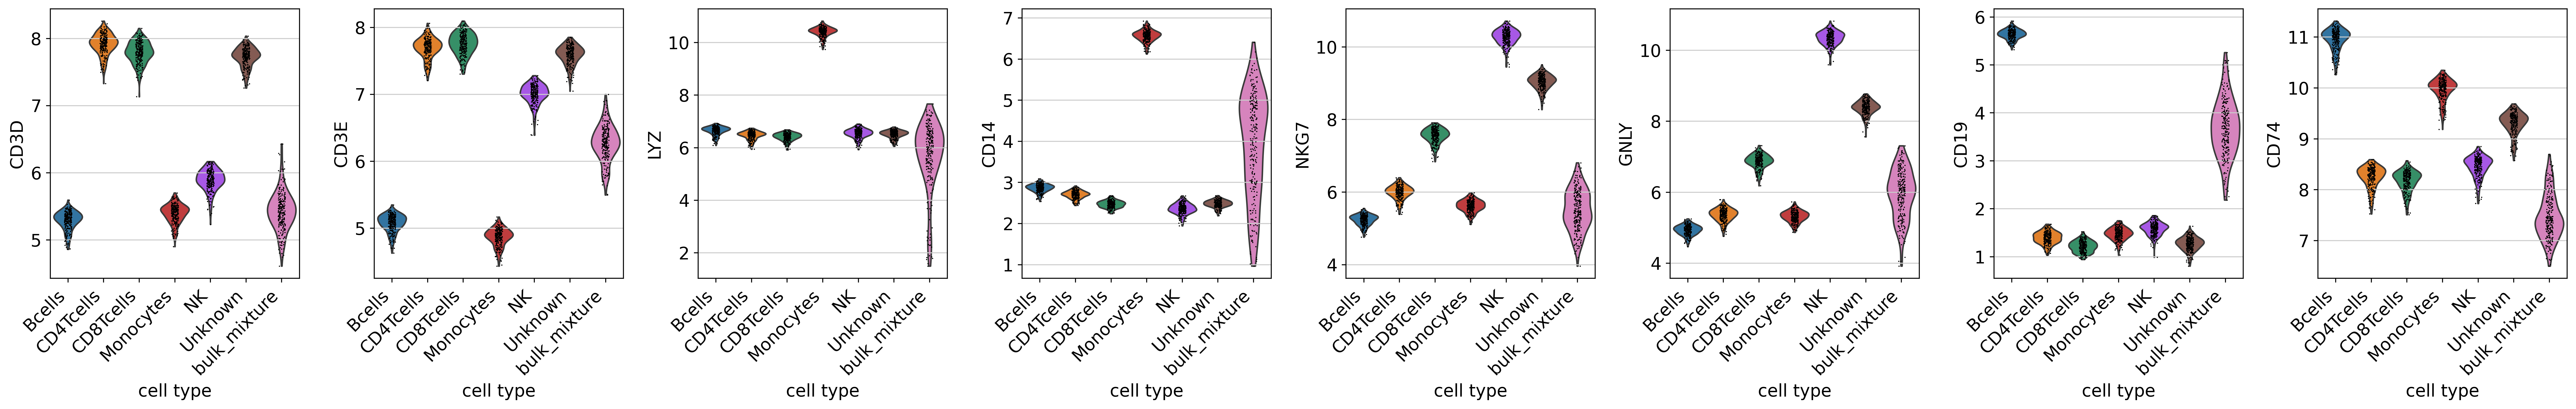

In [75]:
axes=sc.pl.violin(adata_c, keys=cell_type_markers, groupby="cell_type", show=False)
for ax in axes:
    ax.set_xticklabels(adata_c.obs.cell_type.cat.categories, rotation=45, ha="right")

## Matrixplot

         Falling back to preprocessing with `sc.pp.pca` and default params.


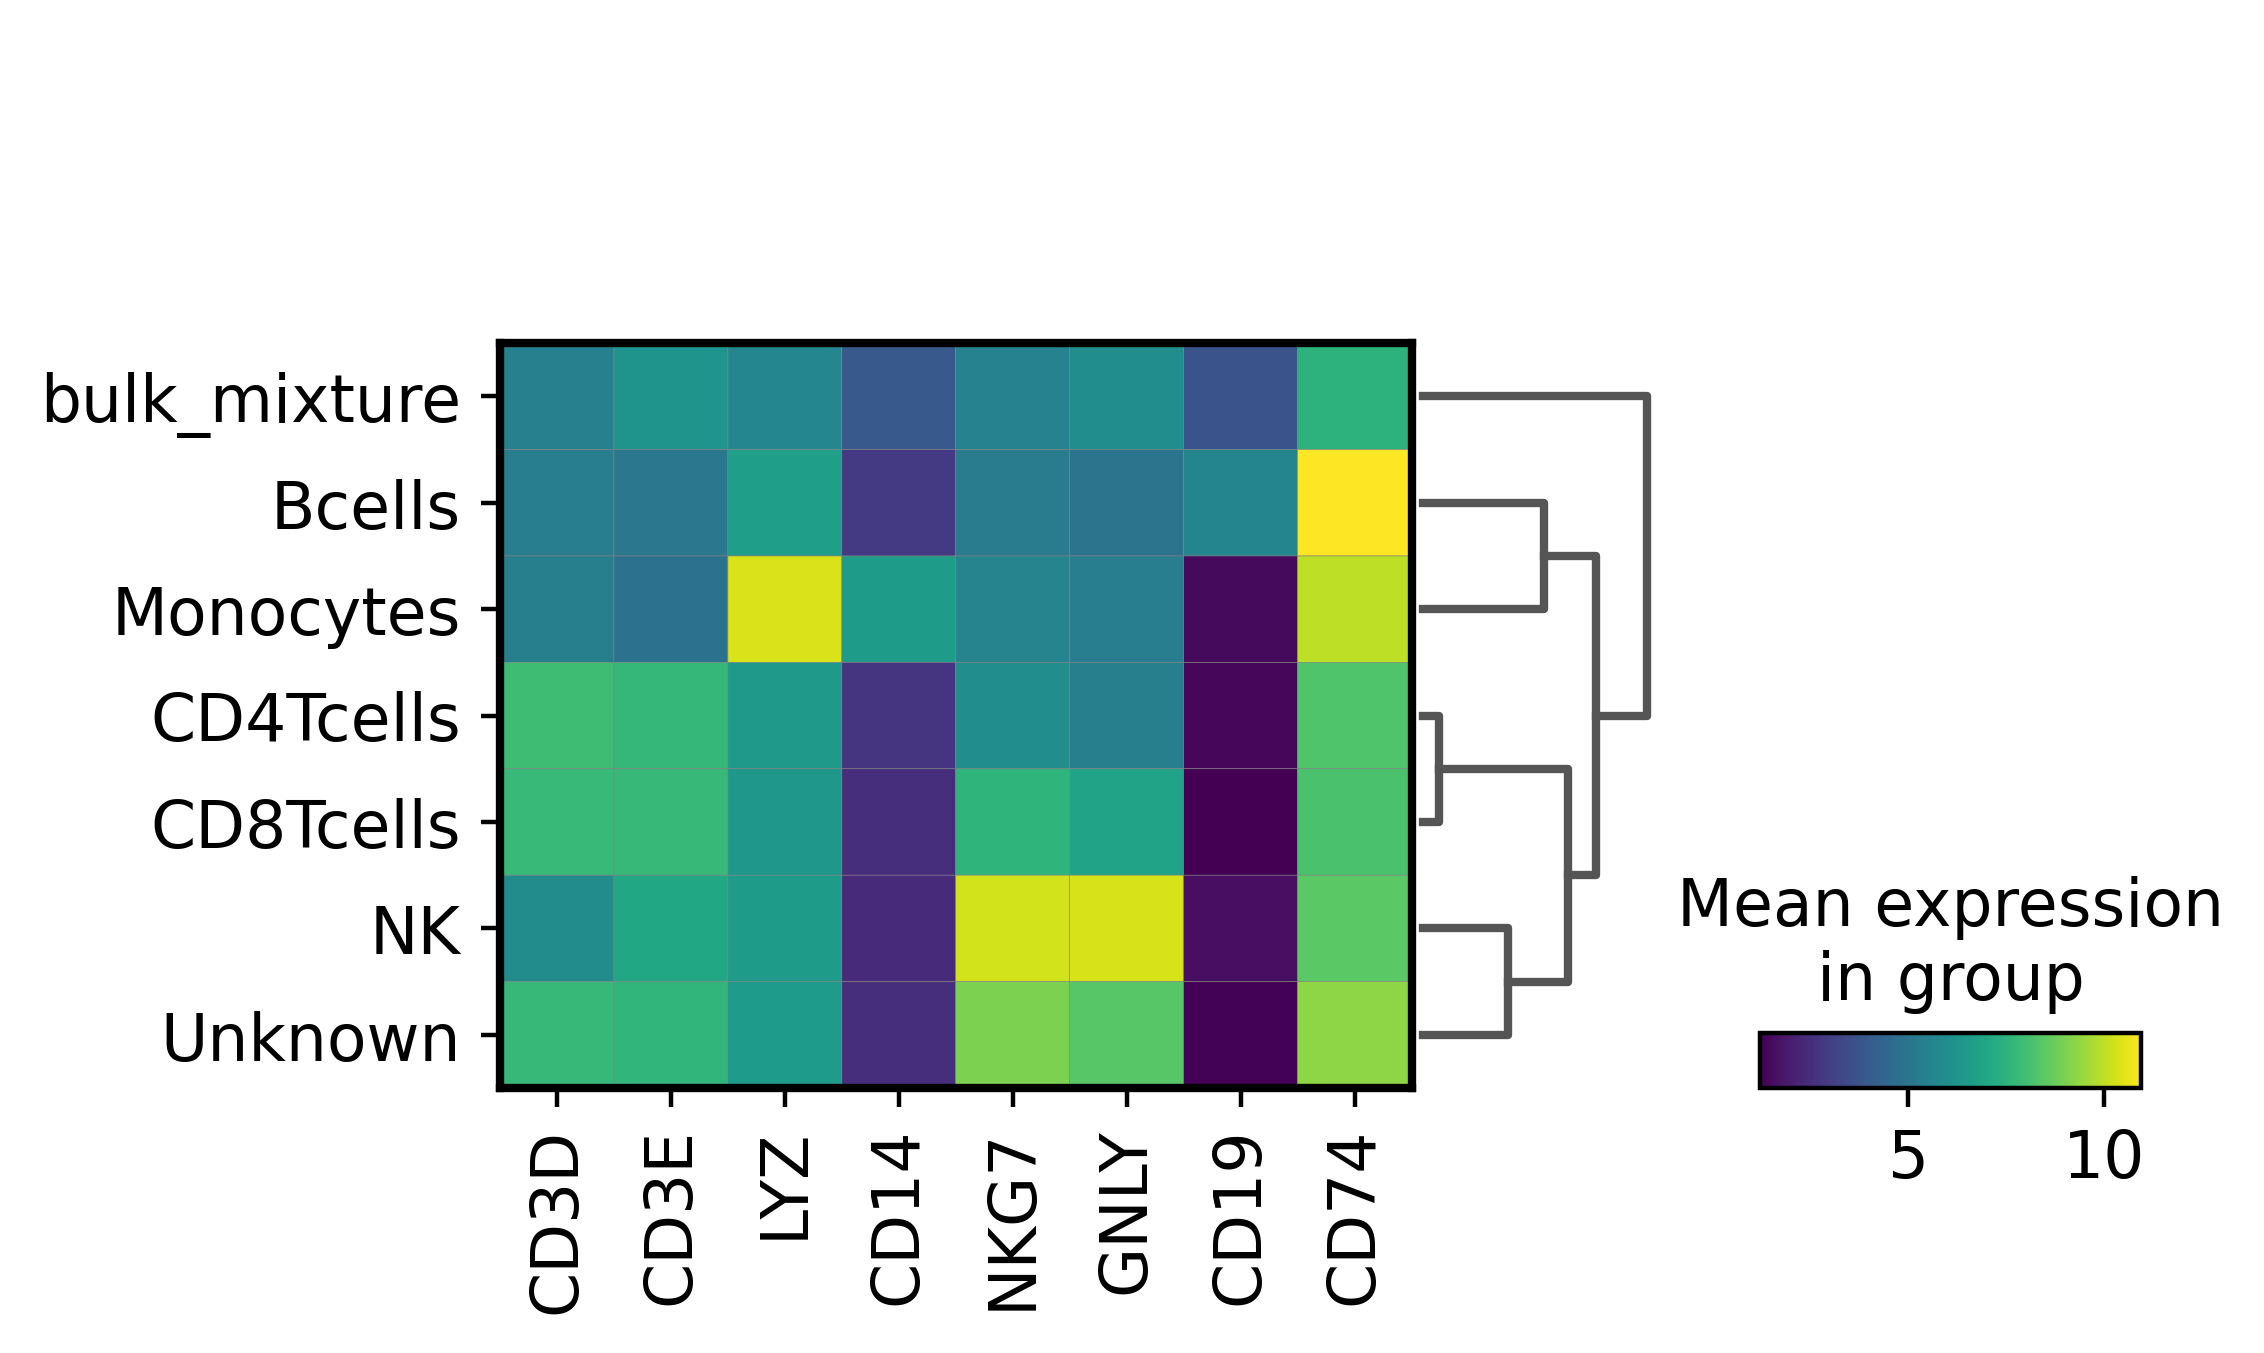

In [76]:
sc.pl.matrixplot(adata_c, var_names=cell_type_markers, groupby="cell_type", dendrogram=True)